In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

## Data preprocessing

In [169]:
df = pd.read_csv('./train.csv')
df = df.drop('Id', 1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [170]:
enc_features = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
               'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual',
               'OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
               'ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
               'Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
               'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature',
               'SaleType','SaleCondition']
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,0,0,0,1,0,0,0,0,1,0


In [171]:
real_features = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtUnfSF',
                'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
                'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
                'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
                'MiscVal','MoSold','YrSold']
cat_features = list(set(df.columns.values.tolist()) - set(real_features))
cat_features.remove('SalePrice')
print (real_features)
print (cat_features)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['Neighborhood_MeadowV', 'BldgType_Duplex', 'Exterior1st_AsbShng', 'Neighborhood_CollgCr', 'Exterior2nd_BrkFace', 'Condition1_RRNe', 'Condition2_RRNn', 'HeatingQC_Fa', 'Neighborhood_NPkVill', 'Street_Pave', 'GarageCond_Gd', 'MSSubClass_70', 'RoofStyle_Hip', 'Electrical_Mix', 'Exterior2nd_HdBoard', 'LotShape_IR3', 'Heating_Floor', 'Street_Grvl', 'MSSubClass_50', 'BsmtFinType1_GLQ', 'GarageQual_Fa', 'SaleType_ConLD', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'FireplaceQu_Fa', 'LotShape_IR1', 'BldgType_1Fam', 'Condition2_RRAe', 'HouseStyle_SFoyer', 'R

In [172]:
df[real_features].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,567.240411,1057.429452,1162.626712,346.992466,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,441.866955,438.705324,386.587738,436.528436,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,477.500000,991.500000,1087.000000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,808.000000,1298.250000,1391.250000,728.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,2336.000000,6110.000000,4692.000000,2065.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [173]:
df[cat_features].describe()

,Neighborhood_MeadowV,BldgType_Duplex,Exterior1st_AsbShng,Neighborhood_CollgCr,Exterior2nd_BrkFace,Condition1_RRNe,Condition2_RRNn,HeatingQC_Fa,Neighborhood_NPkVill,Street_Pave,...,CentralAir_Y,BsmtCond_Gd,Neighborhood_Gilbert,Condition2_Feedr,Exterior1st_Plywood,KitchenQual_TA,GarageCond_Fa,ExterCond_Fa,Functional_Typ,BsmtFinType1_BLQ
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.011644,0.035616,0.013699,0.102740,0.017123,0.001370,0.001370,0.033562,0.006164,0.995890,...,0.934932,0.044521,0.054110,0.004110,0.073973,0.503425,0.023973,0.019178,0.931507,0.101370
std,0.107313,0.185395,0.116277,0.303723,0.129775,0.036999,0.036999,0.180160,0.078298,0.063996,...,0.246731,0.206319,0.226311,0.063996,0.261816,0.500160,0.153016,0.137198,0.252677,0.301921
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [174]:
print (df.shape)

(1460, 320)


In [175]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)
for ft in cat_features:
    df[ft] = df[ft].fillna(0)    

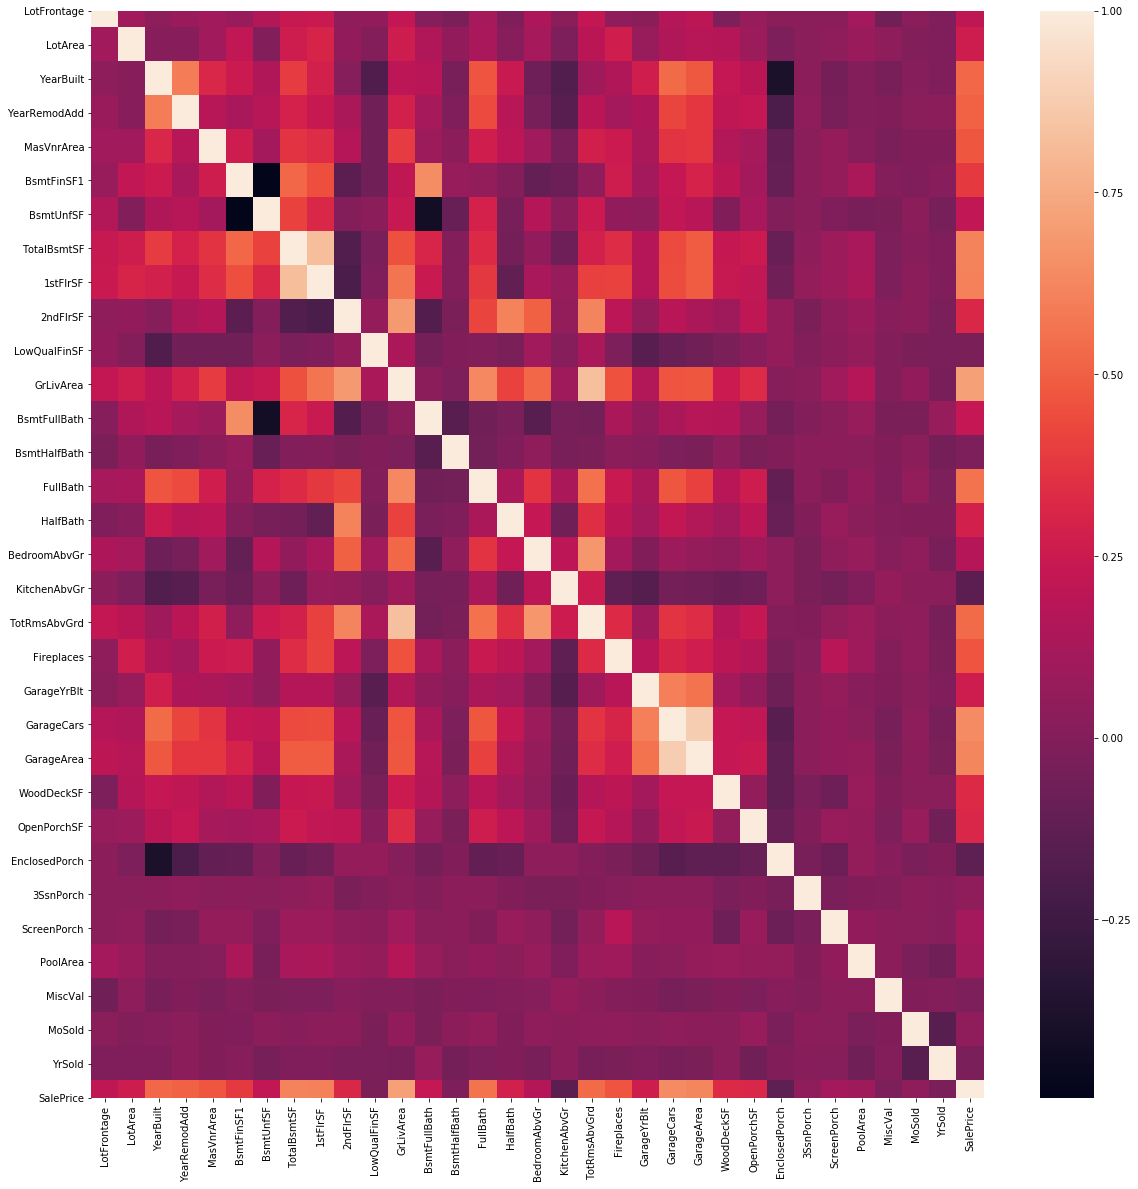

In [176]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[real_features + ['SalePrice']].corr())

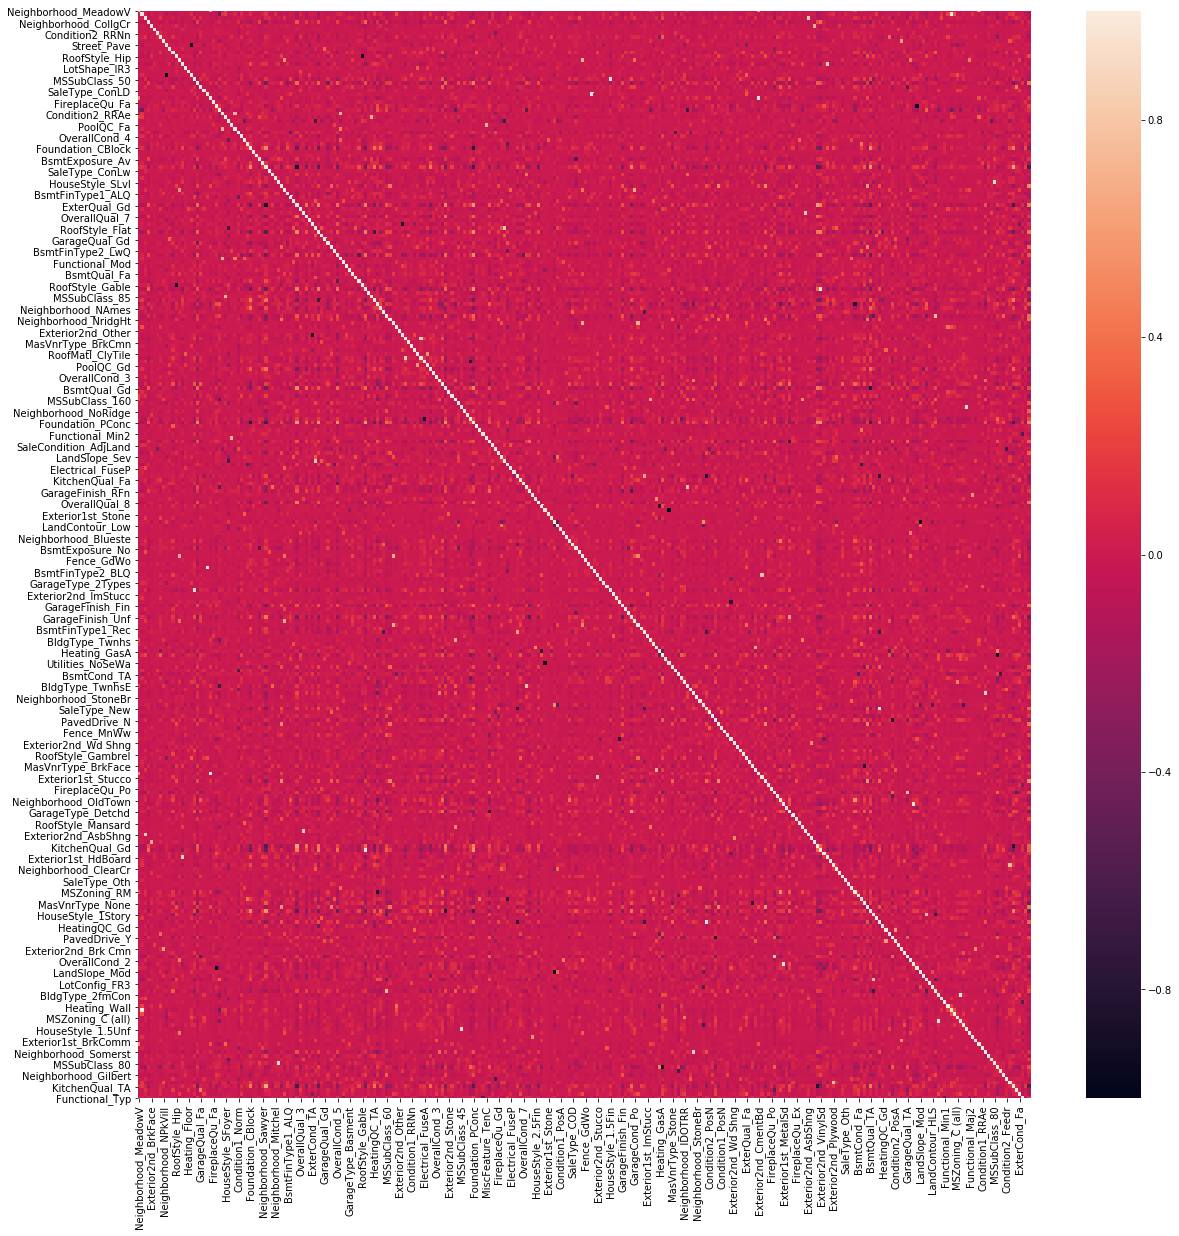

In [177]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[cat_features + ['SalePrice']].corr())

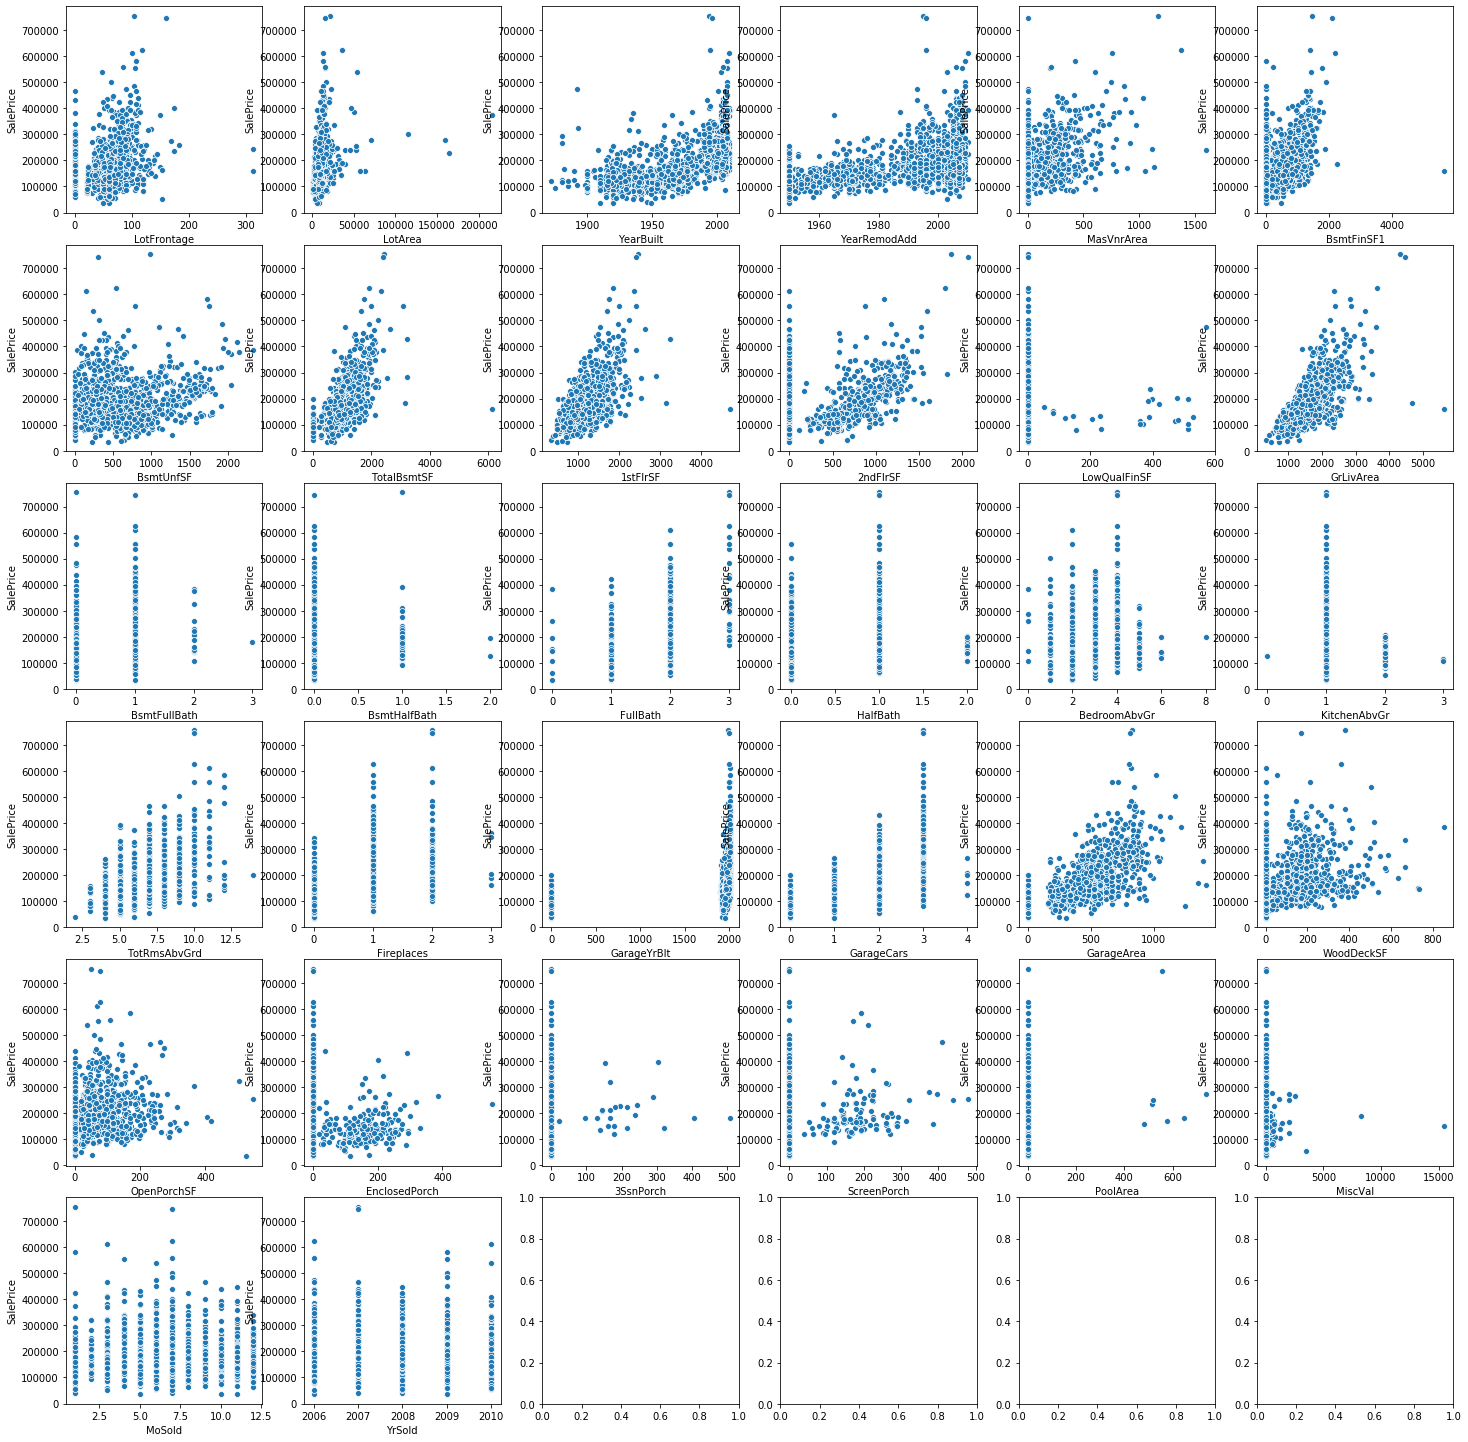

In [178]:
fig, ax = plt.subplots(6, 6, figsize=(20, 20))
fig.tight_layout()
ax = iter(ax.flatten())
for feat in real_features:
    sns.scatterplot(x=feat, y='SalePrice', data=df, ax=next(ax))

In [179]:
y = df['SalePrice'].to_numpy()
df = df.drop('SalePrice', 1)

X_real = df[real_features].to_numpy()
X_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_real[0]))
print ("X_cat: {} ".format(X_cat[0]))
print ("y: {} ".format(y[0]))

X_real: [6.500e+01 8.450e+03 2.003e+03 2.003e+03 1.960e+02 7.060e+02 1.500e+02
 8.560e+02 8.560e+02 8.540e+02 0.000e+00 1.710e+03 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 3.000e+00 1.000e+00 8.000e+00 0.000e+00 2.003e+03
 2.000e+00 5.480e+02 0.000e+00 6.100e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.000e+00 2.008e+03] 
X_cat: [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0] 
y: 208500 


### Polynomial features

In [180]:
transform = PolynomialFeatures(2)
X_poly_real = transform.fit_transform(X_real)

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_poly_real)

In [73]:
print (X_real_scaled.shape)
print (X_cat.shape)
print (y.shape)

(1460, 561)
(1460, 287)
(1460,)


### Checking dataset

In [74]:
#(X_train_real, X_test_real, X_train_cat, X_test_cat, 
# y_train, y_test) = train_test_split(X_real_scaled, X_cat, y, test_size=0.3, random_state=0)
#print (X_train_real.shape, X_test_real.shape)
#print (X_train_cat.shape, X_test_cat.shape)

#print (y_train.shape, y_test.shape)

In [75]:
#X_train = np.hstack((X_train_real, X_train_cat))
#X_test = np.hstack((X_test_real, X_test_cat))
X = np.hstack((X_real_scaled, X_cat))

In [76]:
xi = np.isfinite(X) 
print (xi[np.where(xi == False)].sum())

xn = np.isnan(X) 
print (xn[np.where(xn == False)].sum())

0
0


In [77]:
yi = np.isfinite(y) 
print (yi[np.where(yi == False)].sum())

yn = np.isnan(y) 
print (yn[np.where(yn == False)].sum())

0
0


## Features selection with Lasso

In [78]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [79]:
param_grid = {'alpha': [30.0], 'max_iter': [100000]}
estimator = Lasso()

optimizer = GridSearchCV(estimator, param_grid, cv=10)
optimizer.fit(X, y)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [30.0], 'max_iter': [100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [80]:
c = 0
not_null_idx = []
for cf in optimizer.best_estimator_.coef_:
    if cf != 0:
        not_null_idx.append(c)
    c += 1
print (len(not_null_idx))    
print (not_null_idx)    

406
[15, 16, 22, 34, 35, 37, 38, 39, 42, 45, 47, 48, 49, 51, 52, 53, 55, 56, 57, 59, 63, 66, 68, 69, 72, 74, 75, 76, 83, 85, 86, 87, 88, 90, 93, 94, 96, 97, 99, 101, 110, 119, 130, 134, 140, 147, 152, 153, 155, 156, 157, 159, 163, 164, 165, 166, 167, 171, 173, 174, 175, 176, 177, 178, 179, 181, 184, 187, 192, 194, 196, 197, 200, 201, 202, 203, 207, 210, 213, 216, 217, 218, 219, 220, 221, 223, 224, 225, 227, 228, 229, 230, 231, 234, 241, 242, 245, 246, 247, 250, 253, 254, 256, 258, 259, 261, 264, 265, 266, 267, 268, 271, 272, 274, 277, 278, 279, 282, 283, 292, 294, 297, 298, 301, 302, 303, 304, 310, 311, 312, 313, 315, 317, 319, 321, 322, 323, 324, 325, 326, 327, 332, 333, 334, 338, 343, 349, 353, 354, 356, 358, 359, 361, 362, 363, 364, 365, 366, 368, 369, 371, 372, 373, 374, 376, 377, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 392, 395, 398, 399, 400, 401, 402, 406, 407, 408, 412, 413, 415, 416, 417, 418, 419, 420, 421, 423, 424, 425, 428, 429, 432, 433, 438, 439, 441, 443, 445,

In [81]:
X = X[:, not_null_idx]
print (X.shape)

(1460, 406)


## Linear regression

### Ridge

In [82]:
rg_model = Ridge(alpha=.5)

score = cross_val_score(rg_model, X, y, cv=10)
score_mean = score.mean()

In [83]:
print (score_mean)

0.8309247694925208


In [84]:
score = cross_val_score(rg_model, X, y, cv=5)
score_mean = score.mean()

In [85]:
print (score_mean)

0.8336801991333079


In [86]:
param_grid = {
    'alpha': [0.01, 0.02, 0.05, 0.07, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5, 10, 20, 30]
}
estimator = Ridge()

rg2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
rg2_model.fit(X, y)

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    6.5s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.02, 0.05, 0.07, 0.08, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5, 10, 20,
                                   30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [90]:
print (rg2_model.best_estimator_)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)


In [99]:
print (rg2_model.best_score_)

0.8567429614808802


### ElasticNet

In [92]:
el_model = ElasticNet(alpha=.5, l1_ratio=.5, max_iter=100000)

score = cross_val_score(el_model, X, y, cv=10)
score_mean = score.mean()

In [93]:
print (score_mean)

0.7987542212770581


In [94]:
score = cross_val_score(el_model, X, y, cv=5)
score_mean = score.mean()

In [95]:
print (score_mean)

0.783952918386764


In [96]:
param_grid = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 5., 10.], 
              'l1_ratio': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
              'max_iter': [100000]}
estimator = ElasticNet()

el2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
el2_model.fit(X, y)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  4.4min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 5.0, 10.0],
                         'l1_ratio': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                         'max_iter': [100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [97]:
print (el2_model.best_estimator_)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.8,
           max_iter=100000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [100]:
print (el2_model.best_score_)

0.844259300962397


### LassoLars

In [101]:
la_model = LassoLars(alpha=.5, max_iter=30)

score = cross_val_score(la_model, X, y, cv=10)
score_mean = score.mean()

In [102]:
print (score_mean)

0.7770900671301283


In [103]:
score = cross_val_score(la_model, X, y, cv=5)
score_mean = score.mean()

In [104]:
print (score_mean)

0.7719444706852655


In [105]:
param_grid = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 5., 10.], 'max_iter': [30, 20]
}
estimator = LassoLars(max_iter=30)

la2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
la2_model.fit(X, y)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    7.7s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LassoLars(alpha=1.0, copy_X=True,
                                 eps=2.220446049250313e-16, fit_intercept=True,
                                 fit_path=True, max_iter=30, normalize=True,
                                 positive=False, precompute='auto',
                                 verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 5.0, 10.0],
                         'max_iter': [30, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [106]:
print (la2_model.best_estimator_)

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=30, normalize=True, positive=False,
          precompute='auto', verbose=False)


In [107]:
print (la2_model.best_score_)

0.7770900671301281


## Random Forest

In [108]:
from sklearn.ensemble import RandomForestRegressor

In [109]:
rf_model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)

score = cross_val_score(rf_model, X, y, cv=10)
score_mean = score.mean()

In [110]:
print (score_mean)

0.8138293707483062


In [111]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700], 'max_depth': [2, 3, 4, 5, 10]
}
estimator = RandomForestRegressor()

rf2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
rf2_model.fit(X, y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  6.5min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 10],
 

In [112]:
print (rf2_model.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [113]:
print (rf2_model.best_score_)


0.8458763090215361


## XGBoost

In [114]:
from xgboost import XGBRegressor

In [115]:
xgb_model = XGBRegressor()

score = cross_val_score(xgb_model, X, y, cv=10)
score_mean = score.mean()

[17:25:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [116]:
print (score_mean)

0.8823185134099676


In [119]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [2, 3],
    'gamma': [0.1, 0.2, 0.3],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'n_estimators': [100, 200, 300, 400, 500]
}
estimator = XGBRegressor()

xgb2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
xgb2_model.fit(X, y)

Fitting 10 folds for each of 810 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 5392 tasks      | elapsed: 41.0min
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed: 49.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | e

[18:59:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6],
                         'gamma': [0.1, 0.2, 0.3],
                         'learning_rate': [0.05, 0.1, 0.2],
           

In [120]:
print (xgb2_model.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.1,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=2, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


In [121]:
print (xgb2_model.best_score_)

0.890686747146136


## Voting

In [122]:
from sklearn.ensemble import VotingRegressor

In [125]:
vt_model = VotingRegressor([
    ('rg', rg2_model.best_estimator_),    
    ('gb', xgb2_model.best_estimator_)
], n_jobs=-1, verbose=3)

print (vt_model)

VotingRegressor(estimators=[('rg',
                             Ridge(alpha=5, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001)),
                            ('gb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.4, gamma=0.1,
                                          importance_type='gain',
                                          learning_rate=0.05, max_delta_step=0,
                                          max_depth=3, min_child_weight=2,
                                          missing=None, n_estimators=500,
                                          n_jobs=1, nthread=None,
                                

In [127]:
score = cross_val_score(vt_model, X, y, cv=10)
score_mean = score.mean()

[19:17:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:17:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:17:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:17:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:17:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:17:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:18:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:18:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [128]:
print (score_mean)

0.8921307588731509


In [161]:
vt_model.fit(X, y)

[19:20:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


VotingRegressor(estimators=[('rg',
                             Ridge(alpha=5, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001)),
                            ('gb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.4, gamma=0.1,
                                          importance_type='gain',
                                          learning_rate=0.05, max_delta_step=0,
                                          max_depth=3, min_child_weight=2,
                                          missing=None, n_estimators=500,
                                          n_jobs=1, nthread=None,
                                

In [194]:
vt2_model = VotingRegressor([    
    ('el', el2_model.best_estimator_), 
    ('rf', rf2_model.best_estimator_)
], n_jobs=-1, verbose=3)

print (vt2_model)

VotingRegressor(estimators=[('el',
                             ElasticNet(alpha=0.1, copy_X=True,
                                        fit_intercept=True, l1_ratio=0.8,
                                        max_iter=100000, normalize=False,
                                        positive=False, precompute=False,
                                        random_state=None, selection='cyclic',
                                        tol=0.0001, warm_start=False)),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=10,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=N

In [195]:
score = cross_val_score(vt2_model, X, y, cv=10)
score_mean = score.mean()

In [196]:
print (score_mean)

0.8655559855091308


In [197]:
vt2_model.fit(X, y)

VotingRegressor(estimators=[('el',
                             ElasticNet(alpha=0.1, copy_X=True,
                                        fit_intercept=True, l1_ratio=0.8,
                                        max_iter=100000, normalize=False,
                                        positive=False, precompute=False,
                                        random_state=None, selection='cyclic',
                                        tol=0.0001, warm_start=False)),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=10,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=N

### LR submission

In [181]:
df_train = df.copy()

df = pd.read_csv('./test.csv')
house_ids = df['Id'].to_numpy()
df = df.drop('Id', 1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [182]:
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,80.0,11622,1961,1961,0.0,468.0,144.0,270.0,882.0,896,...,0,0,0,1,0,0,0,0,1,0
1,81.0,14267,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,...,0,0,0,1,0,0,0,0,1,0
2,74.0,13830,1997,1998,0.0,791.0,0.0,137.0,928.0,928,...,0,0,0,1,0,0,0,0,1,0
3,78.0,9978,1998,1998,20.0,602.0,0.0,324.0,926.0,926,...,0,0,0,1,0,0,0,0,1,0
4,43.0,5005,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,...,0,0,0,1,0,0,0,0,1,0


In [183]:
features_diff = list(set(df_train.columns.values.tolist()) - set(df.columns.values.tolist()))
print (len(features_diff), features_diff)
zeros = np.zeros(df.shape[0])

for ft in features_diff:
    df[ft] = pd.Series(zeros)

18 ['Condition2_RRAn', 'PoolQC_Fa', 'MiscFeature_TenC', 'HouseStyle_2.5Fin', 'RoofMatl_ClyTile', 'Electrical_Mix', 'Exterior2nd_Other', 'RoofMatl_Metal', 'RoofMatl_Membran', 'Condition2_RRNn', 'Heating_Floor', 'Exterior1st_Stone', 'Utilities_NoSeWa', 'GarageQual_Ex', 'Heating_OthW', 'Condition2_RRAe', 'Exterior1st_ImStucc', 'RoofMatl_Roll']


In [184]:
df[real_features].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1232.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,68.580357,9819.161069,1971.357779,1983.662783,100.709141,439.203704,554.294925,1046.117970,1156.534613,325.967786,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,22.376841,4955.517327,30.390071,21.130467,177.625900,455.268042,437.260486,442.898624,398.165820,420.610226,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,21.000000,1470.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,58.000000,7391.000000,1953.000000,1963.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,67.000000,9399.000000,1973.000000,1992.000000,0.000000,350.500000,460.000000,988.000000,1079.000000,0.000000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11517.500000,2001.000000,2004.000000,164.000000,753.500000,797.750000,1305.000000,1382.500000,676.000000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,200.000000,56600.000000,2010.000000,2010.000000,1290.000000,4010.000000,2140.000000,5095.000000,5095.000000,1862.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [185]:
df[cat_features].describe()

,Neighborhood_MeadowV,BldgType_Duplex,Exterior1st_AsbShng,Neighborhood_CollgCr,Exterior2nd_BrkFace,Condition1_RRNe,Condition2_RRNn,HeatingQC_Fa,Neighborhood_NPkVill,Street_Pave,...,CentralAir_Y,BsmtCond_Gd,Neighborhood_Gilbert,Condition2_Feedr,Exterior1st_Plywood,KitchenQual_TA,GarageCond_Fa,ExterCond_Fa,Functional_Typ,BsmtFinType1_BLQ
count,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.000000,1459.0,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,0.013708,0.039068,0.01645,0.080192,0.015079,0.002742,0.0,0.029472,0.009596,0.995888,...,0.930775,0.039068,0.058944,0.004798,0.077450,0.518849,0.026731,0.026731,0.930089,0.082934
std,0.116316,0.193823,0.12724,0.271683,0.121908,0.052306,0.0,0.169184,0.097520,0.064018,...,0.253924,0.193823,0.235602,0.069124,0.267396,0.499816,0.161350,0.161350,0.255084,0.275876
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [186]:
print (df.shape)

(1459, 320)


In [187]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)
for ft in cat_features:
    df[ft] = df[ft].fillna(0) 

In [188]:
X_testing_real = df[real_features].to_numpy()
X_testing_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_testing_real[0]))
print ("X_cat: {} ".format(X_testing_cat[0]))

X_real: [8.0000e+01 1.1622e+04 1.9610e+03 1.9610e+03 0.0000e+00 4.6800e+02
 2.7000e+02 8.8200e+02 8.9600e+02 0.0000e+00 0.0000e+00 8.9600e+02
 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 2.0000e+00 1.0000e+00
 5.0000e+00 0.0000e+00 1.9610e+03 1.0000e+00 7.3000e+02 1.4000e+02
 0.0000e+00 0.0000e+00 0.0000e+00 1.2000e+02 0.0000e+00 0.0000e+00
 6.0000e+00 2.0100e+03] 
X_cat: [  0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.
   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
   0.   1.   1.   1.   0.   0.   1.   0.   1.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
   0.   1.   0.   1.   0.   0.   0.   0.   0.   0.   1.  

In [189]:
X_testing_poly_real = transform.fit_transform(X_testing_real)

In [190]:
X_testing_real_scaled = scaler.fit_transform(X_testing_poly_real)

In [191]:
X_testing = np.hstack((X_testing_real_scaled, X_testing_cat))

X_testing = X_testing[:, not_null_idx]
print (X_testing.shape)

(1459, 406)


In [192]:
predicted = vt_model.predict(X_testing)

print (predicted)
print (house_ids)

[114044.09073458 159421.92112872 199087.27710067 ... 180319.3945914
 112808.33800307 225413.77591478]
[1461 1462 1463 ... 2917 2918 2919]


In [193]:
with open("submission_vt.txt", "w") as fout:
    fout.write("Id,SalePrice\n")
    for val in zip(house_ids, predicted):
        fout.write("{},{}\n".format(str(int(val[0])), str(int(val[1]))))